# Bayesian Neural Network

In [1]:
import os
import sys
import matplotlib.pyplot as plt
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)

from main import *

c:\Users\SSosa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Gaussian neural network
### Simulate data
We generate training and test data from a Bayesian neural network model. in order evaluate accuracy of the model.


In [29]:
lk

Array([ 79.88315721,  68.30468447, 120.32173345, ...,  94.99927067,
        76.604384  ,  91.62806767], dtype=float64)

In [30]:
y

Array([ 69.59105024,  29.06639565, 211.12606709, ..., 122.49744733,
        58.11534401, 110.69823686], dtype=float64)

jax.local_device_count 16


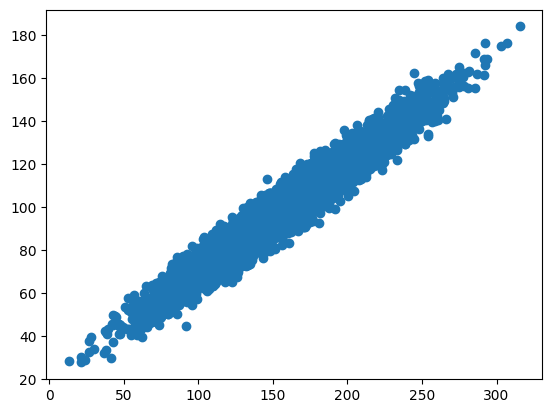

In [51]:

# setup platform------------------------------------------------
m = bi(platform='cpu')
alpha= 20
beta = 0.5
sigma= 5
x=m.dist.normal(160, 40,sample=True,shape=(10000,))
lk=alpha+beta*x
y=bi.dist.normal(lk, sigma,sample=True,seed=2)
data=jnp.array([x,y]).T

def split_train_test(arr):
    # Get the length of the array
    n = arr.shape[0]
    
    # Calculate the split index (80% for training)
    train_idx = int(n * 0.8)
    
    # Generate a random permutation of indices
    key = jax.random.PRNGKey(0)  # You can use a fixed key for reproducibility
    permuted_indices = jax.random.permutation(key, n)
    
    # Split the permuted indices
    train_indices = permuted_indices[:train_idx]
    test_indices = permuted_indices[train_idx:]
    
    # Split the original array based on the indices
    train_set = arr[train_indices]
    test_set = arr[test_indices]
    
    return train_set, test_set

train, test = split_train_test(data)

dataTrain= dict(X=train[:,0].reshape((8000,1)),Y=train[:,1].reshape((8000,1)))

m.data_on_model=dataTrain

plt.scatter(dataTrain['X'], dataTrain['Y'])

In [ ]:

def activation(x):
    return jnp.tanh(x)

# define model ------------------------------------------------
def model(X, Y, D_X=1, D_H=5, D_Y=1):  
    N = X.shape[0]  
    # sample first layer (we put unit normal priors on all weights)
    # First hidden layer: Transforms input to N × D_H (hidden units)
    w1 = dist.normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H)),  name='w1',shape=(D_X,D_H))
    z1 = activation(jnp.matmul(X, w1))  # <= first layer of activations

    # sample second layer
    # Second hidden layer: Further transforms to N × D_H
    w2 = dist.normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H)),  name='w2',shape=(D_H,D_H))
    z2 = activation(jnp.matmul(z1, w2))  # <= second layer of activations


    # sample final layer of weights and neural network output
    # Final layer (z3) computes linear combination of second hidden layer
    w3 = dist.normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y)),  name='w3',shape=(D_H,D_Y))

    z3 = jnp.matmul(z2, w3)  # <= output of the neural network

    # we put a prior on the observation noise
    prec_obs = dist.uniform(0, 50,shape=(N,D_Y),name='prec_obs')
    sigma_obs = 1.0 / jnp.sqrt(prec_obs)

    m.normal(z3, sigma_obs, obs=Y, shape=(N,1))


# Run sampler ------------------------------------------------
m.run(model, num_samples=500) 


warmup:   6%|▌         | 55/1000 [00:18<28:47,  1.83s/it, 1023 steps of size 1.55e-06. acc. prob=0.68]

In [ ]:
def find_obs_in_model(model_func):
    """
    Extract observed argument names from `obs` in `lk` calls in `model_func`.
    """
    # Get the source code of the function
    source_code = inspect.getsource(model)
    # Parse the source code into an Abstract Syntax Tree
    tree = ast.parse(source_code)
    # List to hold the 'obs' values
    obs_values = []

    # Traverse the AST to find all function calls with 'obs' keyword argument
    for node in ast.walk(tree):
        if isinstance(node, ast.Call):
            for keyword in node.keywords:
                if keyword.arg == 'obs':
                    # Extract the value passed to 'obs'
                    value = ast.unparse(keyword.value)
                    obs_values.append(value)
    self.obs_args = obs_values
    return obs_values
self=m
find_obs_in_model(model)

['Y']

In [ ]:
def build_model_with_Y_None(model):
    '''
    This function modifies the original model function to make the observed arguments optional. This is useful for scenarios where you want to use the model for prediction without providing the observed data (e.g., when generating posterior predictions).
    '''
    # Extract `obs` argument names
    obs = find_obs_in_model(model)
    # Modify the function's signature to make the observed argument optional
    sig = inspect.signature(model)
    parameters = []
    for name, param in sig.parameters.items():
        if name in obs:
            parameters.append(inspect.Parameter(name, inspect.Parameter.POSITIONAL_OR_KEYWORD, default=None))
        else:
            parameters.append(param)
    def model_with_None(*args, **kwargs):
        # Default values for obs arguments if not passed
        for obs_name in obs:
            if obs_name not in kwargs:
                kwargs[obs_name] = None
        # Call the original model function with the modified arguments
        return model(*args, **kwargs)
    # Update the signature of the new model
    model_with_None.__signature__ = sig.replace(parameters=parameters)
    self.model2 = model_with_None
    return model_with_None
build_model_with_Y_None(model)
self.model2

<function __main__.build_model_with_Y_None.<locals>.model_with_None(X, Y=None, D_X=1, D_H=5, D_Y=1)>

In [ ]:

rng_key = jax.random.PRNGKey(int(0))
samples=self.sampler.get_samples()
posterior = self.get_posterior_means()
predictive = Predictive(self.model2, posterior_samples=posterior, num_samples=samples)
pred=predictive(rng_key, X=test[:,0].reshape(2000,1), Y=None)
pred.keys() 

C:\Users\SSosa\AppData\Local\Temp\ipykernel_32508\3975661026.py:4: UserWarning: Sample's batch dimension size 1 is different from the provided {'w1': Array([[[ 1.64676615, -0.00540194,  0.92601218, -1.69641062,
         -0.6943928 ]],

       [[ 1.64676861, -0.00539839,  0.92600925, -1.69638039,
         -0.69438675]],

       [[ 1.64676255, -0.00540462,  0.92599978, -1.69638116,
         -0.69438833]],

       ...,

       [[ 1.64654724, -0.00536891,  0.92562959, -1.69580607,
         -0.69390224]],

       [[ 1.64655208, -0.00536608,  0.9256259 , -1.69580686,
         -0.6939072 ]],

       [[ 1.64655456, -0.00536304,  0.92563073, -1.6958085 ,
         -0.69391485]]], dtype=float64), 'w2': Array([[[-0.56735796,  1.48484404, -2.11552606,  1.95705943,
         -0.74031705],
        [-2.49391606, -1.54011885,  0.02333647,  0.84077299,
          1.29181828],
        [ 0.56494855,  0.58735493,  0.21273623,  2.71027677,
         -1.12478334],
        [ 0.07608202, -1.03846745,  1.87665431,

dict_keys(['w1', 'w2', 'w3', 'x'])

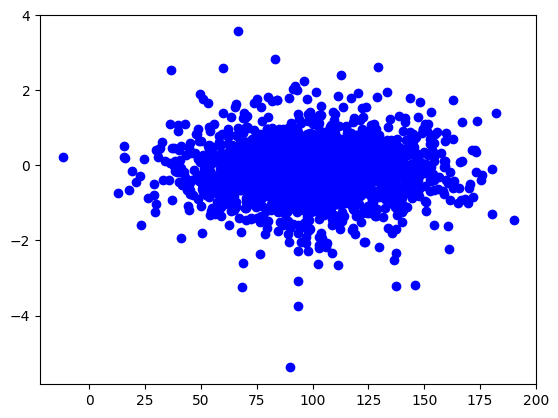

In [ ]:
predictions=pred['x'][..., 0]
plt.scatter(test[:,1], predictions, label='y = f(x)', color='b', marker='o')